<a href="https://colab.research.google.com/github/monsund/unsupervised-classification-of-Linkedin-Profiles-using-KMeans-LDA-TFIDF/blob/master/TFIDF_kmeans_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing necessary Libraries**

In [1]:
import os
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline

# **Loading Dataset**

In [ ]:
input_filepath = '/content/drive/My Drive/NLP/with swaraj/Data'
input_filename = 'linkedin_about.csv'

In [ ]:
df = pd.read_csv(os.path.join(input_filepath,input_filename))
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)  #Reindexing 
df.head(1)

,Unnamed: 0,url,username,title,about
0,0,https://www.linkedin.com/in/lokesh-kumar-xess-...,lokesh-kumar-xess-54814068,Marketing & Strategy at Mobistreak,I am a Google Adwords and Google Analytics cer...


# **Removing Stopwords, Punctuation and Text Lower Case**

In [ ]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = set(stopwords.words('english'))
punct = set(['.', ',', '&', '\'', '"', '(', ')'])
stopwords_punct= stop_words.union(punct)


In [ ]:
# removing stopwords and punctuation
data_without_stopwords_punct = []
for i in range(len(df)):
  word_tokens = word_tokenize(df.about[i].lower())         #lowering case----------------
  filtered_sentence = [w for w in word_tokens if not w in stopwords_punct]
  data_without_stopwords_punct.append(' '.join(filtered_sentence))

In [ ]:
df['cleaned_about_us'] = data_without_stopwords_punct
df.head()

,Unnamed: 0,url,username,title,about,cleaned_about_us
0,0,https://www.linkedin.com/in/lokesh-kumar-xess-...,lokesh-kumar-xess-54814068,Marketing & Strategy at Mobistreak,I am a Google Adwords and Google Analytics cer...,google adwords google analytics certified ppc ...
1,1,https://in.linkedin.com/in/sujithnarayanan,sujithnarayanan,Reimagining Financial Services for India,Ideate. Execute. Disrupt. Iterate.,ideate execute disrupt iterate
2,2,https://www.linkedin.com/in/adarshramakrishnan,adarshramakrishnan,Product Strategist | Product Manager | Triple ...,"Over the past decade, I have co-founded 3 vent...",past decade co-founded 3 ventures elegant solu...
3,3,https://www.linkedin.com/in/rhythm-bhatnagar-4...,rhythm-bhatnagar-4350b551,Product Marketer | Ex-SHEROES | Early-Stage St...,"Hey,I am Rhythm. I am passionate about startup...",hey rhythm passionate startups building deeper...
4,4,https://www.linkedin.com/in/karthiksureshlbs,karthiksureshlbs,Product at Facebook | CMU MS | LBS MBA,I am a product-centric builder with experience...,product-centric builder experience founder ear...


# **Vectorize data with TFIDF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1,2) , max_features=15000)
X = tfidf_vectorizer.fit_transform(df.cleaned_about_us.to_list())
model = X.toarray()
print(len(model), len(model[0]))

9541 15000


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(model)
datapoint = pca.transform(model)

# **Clustering**

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100) 
# X = kmeans_model.fit(model_pvdm.docvecs.doctag_syn0)
X = kmeans_model.fit(model)
labels = kmeans_model.labels_.tolist()

In [ ]:
kmeans_prediction = kmeans_model.fit_predict(model)

# **Elbow method for finding optimal K in Kmeans**

In [ ]:
# function returns Within-Cluster-Sum of Squared Errors (WSS) score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [ ]:
k_size = 10
wss = calculate_WSS(datapoint, k_size)
k = [x for x in range(k_size)]

Text(0, 0.5, 'Value of WSS')

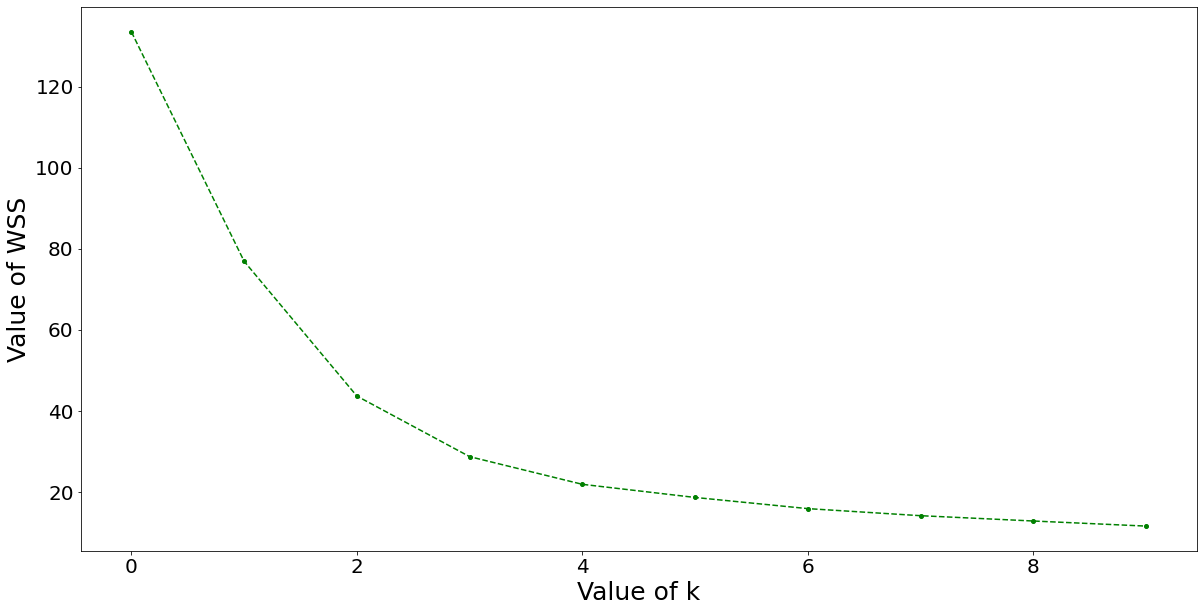

In [ ]:
plt.figure(figsize=(20,10)) # Size of figure is adjusted.
plt.xticks(fontsize=20) # Size of number labels on x-axis is adjusted.
plt.yticks(fontsize=20) # Size of number labels on y-axis is adjusted.
plt.plot(k,wss,'go--', linewidth=1.5, markersize=4) # Graph is plotted.
plt.xlabel('Value of k',fontsize = 25) # x-axis is labelled.
plt.ylabel('Value of WSS',fontsize = 25) # y-axis is labelled.

# ***The Silhouette Method ***

In [ ]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(datapoint)
  labels = kmeans.labels_
  sil.append(silhouette_score(datapoint, labels, metric = 'euclidean'))

In [ ]:
k_sil = [x for x in range(2,21)]

Text(0, 0.5, 'Value of sil')

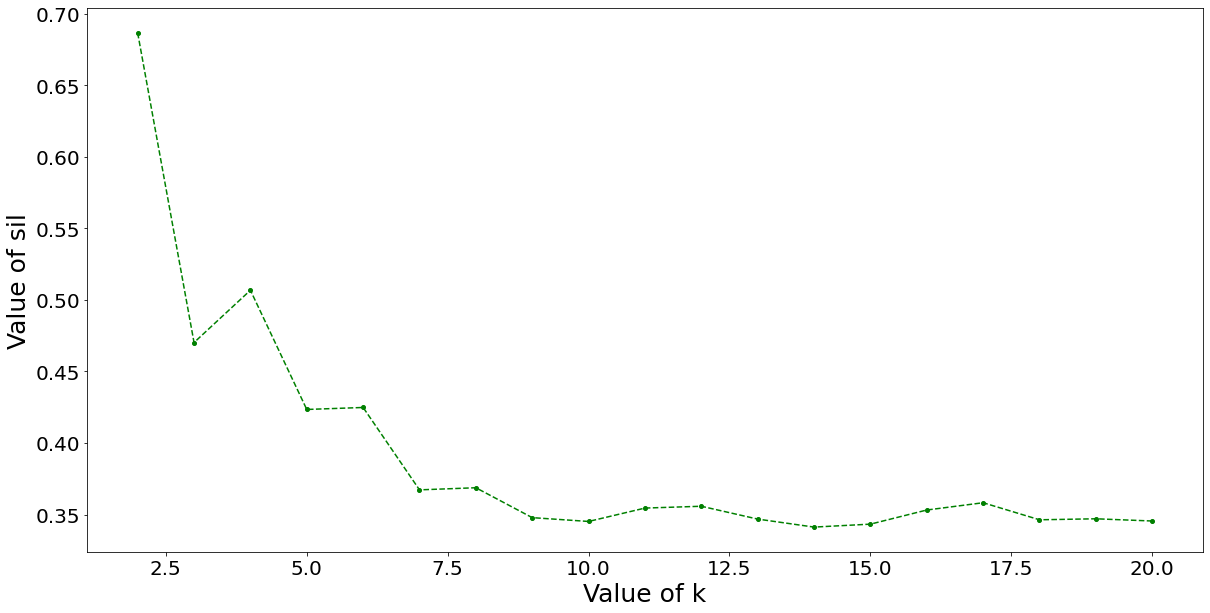

In [ ]:
plt.figure(figsize=(20,10)) # Size of figure is adjusted.
plt.xticks(fontsize=20) # Size of number labels on x-axis is adjusted.
plt.yticks(fontsize=20) # Size of number labels on y-axis is adjusted.
plt.plot(k_sil,sil,'go--', linewidth=1.5, markersize=4) # Graph is plotted.
plt.xlabel('Value of k',fontsize = 25) # x-axis is labelled.
plt.ylabel('Value of sil',fontsize = 25) # y-axis is labelled.

# **Visualization of Clusters**

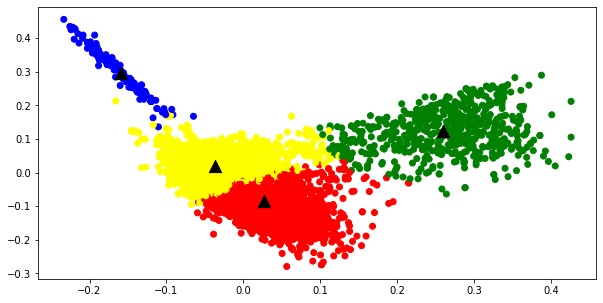

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 5))
# label1 = ['#FFFF00', '#008000', '#0000FF', '#800080', '#800450', '#800FF0', '#112328', '#620000', '#FF00FF', 'orange','#00FF66', '#302B54', '#CDAD00', '#D0FAEE', '#D41A1F']
label1 =['red', 'green', 'yellow', 'blue']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [ ]:
df["cluster"] = kmeans_prediction

df[df["cluster"]==1].head(20)

,Unnamed: 0,url,username,title,about,cleaned_about_us,cluster
0,0,https://www.linkedin.com/in/lokesh-kumar-xess-...,lokesh-kumar-xess-54814068,Marketing & Strategy at Mobistreak,I am a Google Adwords and Google Analytics cer...,google adwords google analytics certified ppc ...,1
6,6,https://www.linkedin.com/in/karthikprabhakar,karthikprabhakar,Executive Director and Partner at Chiratae Ven...,Karthik Prabhakar is the Executive Director an...,karthik prabhakar executive director partner c...,1
10,10,https://www.linkedin.com/in/supadhyay,supadhyay,CEO/GM for AI/SaaS/Data companies,Product and GTM for companies at the intersect...,product gtm companies intersection data aispec...,1
13,13,https://www.linkedin.com/in/leandromargulis,leandromargulis,Business Accelerator | People Connector | Advo...,Entrepreneurial leader with strong Business De...,entrepreneurial leader strong business develop...,1
14,14,https://www.linkedin.com/in/jphillipnelson,jphillipnelson,Product Manager at Google,"I am an experienced entrepreneur, product lead...",experienced entrepreneur product leader softwa...,1
17,17,https://www.linkedin.com/in/jatinmehtaaiqudo,jatinmehtaaiqudo,"VP, Business Development at Aiqudo (Previously...",A senior leader with 15 years of experience in...,senior leader 15 years experience business dev...,1
19,20,https://www.linkedin.com/in/brianli2004,brianli2004,Bizops/CorpDev. Ex-Linkedin. Moved to LA.,Having fun building teams and operations at hi...,fun building teams operations high-growth tech...,1
20,21,https://www.linkedin.com/in/shravansogani,shravansogani,Senior Director Of Engineering at SurveyMonkey,"Passionate, well-grounded, and decisive Engine...",passionate well-grounded decisive engineering ...,1
21,22,https://in.linkedin.com/in/nshntdxt,nshntdxt,Engineering Leader at Slack,"Building high functioning agile teams, one ste...",building high functioning agile teams one step...,1
23,25,https://www.linkedin.com/in/rsudhirshenoy,rsudhirshenoy,"Product Management, Marketing and Channel Mana...",Experienced Professional in the Technology Ind...,experienced professional technology industry r...,1


In [ ]:
print(len(df[df['cluster']==0]))
df[df["cluster"]==0].about.head(10)

171


310     Socio en EntrepreneurlandSocio en FairwindSoci...
923     Problemen oplossen op snijvlak Business - IT, ...
1255    Emprendedor & Programador | Cofundador de Cole...
1457    Co-fundador de Rocketbot, solución de RPA que ...
1480    Antti Kulppi es experto en tecnología y nuevas...
1482    En los últimos años he incubado 5 proyectos es...
1483     En los últimos años he incubado 5 proyectos e...
1557    Building Open Banking en FloidInformación fina...
2478    Orientación y Atención en la Estrategia y Ases...
2907    🔥 DEUX.IO ➭• La meilleure agence de Growth Mar...
Name: about, dtype: object

In [ ]:
df.to_csv('/content/drive/My Drive/NLP/with swaraj/Data/tfidf_kmeans_cluster_results_123.csv', index=False)